# **EXP - 3 - Baby Robot - PART 5**

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

"""
    System Setup
"""

# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

# the true values of each socket
socket_means = [((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)


"""
    Display Setup
"""

# display all floating point numbers to 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


"""
    Helper Functions
"""

# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))



class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self,t):
        """ return an estimate of the socket's reward value """
        return self.Q



class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):

        # create supplied socket type with a mean value defined by socket order
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]

        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        # the index of the best socket is the last in the socket_order list
        # - this is a one-based value so convert to zero-based
        self.optimal_socket_index = (socket_order[-1] - 1)

        # by default a socket tester records 2 bits of information over a run
        self.number_of_stats = kwargs.pop('number_of_stats', 2)


    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """

        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps

        # reset the actual number of steps that the test ran for
        self.total_steps = 0

        # monitor the total reward obtained over the run
        self.total_reward = 0

        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []

        # the actual reward obtained at each timestep
        self.reward_per_timestep = []

        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1,
                                            self.number_of_sockets,
                                            self.number_of_stats))

        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()


    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """

        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward

        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)

        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)


    def get_socket_stats( self, t ):
        """ get the current information from each socket """
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats

    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)

    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep

    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep

    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]

    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]

    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)

    def get_optimal_socket_percentage( self ):
        """ get the percentage of times the optimal socket was tried """
        final_trials = self.socket_stats[:,:,1][self.total_steps]
        return (final_trials[self.optimal_socket_index]/self.total_steps)

    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps


    def select_socket( self, t ):
        """ Greedy Socket Selection"""

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index


    def run( self, number_of_steps, maximum_total_reward = float('inf')):
        """ perform a single run, over the set of sockets,
            for the defined number of steps """

        # reset the run counters
        self.initialize_run(number_of_steps)

        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)

            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)

            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break

        # save the actual number of steps that have been run
        self.total_steps = t

        # get the stats for each socket at the end of the run
        self.socket_stats[t+1] = self.get_socket_stats(t+1)

        return self.total_steps, self.total_reward


class SocketExperiment():
    """ setup and run repeated socket tests to get the average results """

    def __init__(self,
                 socket_tester = SocketTester,
                 number_of_tests = 1000,
                 number_of_steps = 30,
                 maximum_total_reward = float('inf'),
                 **kwargs ):

        self.socket_tester = socket_tester
        self.number_of_tests = number_of_tests
        self.number_of_steps = number_of_steps
        self.maximum_total_reward = maximum_total_reward
        self.number_of_sockets = self.socket_tester.number_of_sockets

    def initialize_run(self):

        # keep track of the average values over the run
        self.mean_total_reward = 0.
        self.optimal_selected = 0.
        self.mean_time_steps = 0.
        self.socket_percentages = np.zeros(self.number_of_sockets)
        self.estimates = np.zeros(shape=(self.number_of_steps+1,self.number_of_sockets))
        self.number_of_trials = np.zeros(shape=(self.number_of_steps+1,self.number_of_sockets))

        # the cumulative total reward per timestep
        self.cumulative_reward_per_timestep = np.zeros(shape=(self.number_of_steps))

        # the actual reward obtained at each timestep
        self.reward_per_timestep = np.zeros(shape=(self.number_of_steps))

    def get_mean_total_reward(self):
        """ the final total reward averaged over the number of timesteps """
        return self.mean_total_reward

    def get_cumulative_reward_per_timestep(self):
        """ the cumulative total reward per timestep """
        return self.cumulative_reward_per_timestep

    def get_reward_per_timestep(self):
        """ the mean actual reward obtained at each timestep """
        return self.reward_per_timestep

    def get_optimal_selected(self):
        """ the mean times the optimal socket was selected """
        return self.optimal_selected

    def get_socket_percentages(self):
        """ the mean of the percentage times each socket was selected """
        return self.socket_percentages

    def get_estimates(self):
        """ per socket reward estimates """
        return self.estimates

    def get_number_of_trials(self):
        """ per socket number of trials """
        return self.number_of_trials

    def get_mean_time_steps(self):
        """ the average number of trials of each test """
        return self.mean_time_steps

    def update_mean( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value """
        return (1 - 1.0/n) * current_mean + (1.0/n) * new_value

    def update_mean_array( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value for an array """

        new_value = np.array(new_value)

        # pad the new array with its last value to make sure its the same length as the original
        pad_length = (current_mean.shape[0] - new_value.shape[0])

        if pad_length > 0:
            new_array = np.pad(new_value,(0,pad_length), mode='constant', constant_values=new_value[-1])
        else:
            new_array = new_value

        return (1 - 1.0/n) * current_mean + (1.0/n) * new_array

    def record_test_stats(self,n):
        """ update the mean value for each statistic being tracked over a run """

        # calculate the new means from the old means and the new value
        tester = self.socket_tester
        self.mean_total_reward = self.update_mean( self.mean_total_reward, tester.get_mean_reward(), n)
        self.optimal_selected = self.update_mean( self.optimal_selected, tester.get_optimal_socket_percentage(), n)
        self.socket_percentages = self.update_mean( self.socket_percentages, tester.get_socket_percentages(), n)
        self.mean_time_steps = self.update_mean( self.mean_time_steps, tester.get_time_steps(), n)

        self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep,
                                                                      tester.get_total_reward_per_timestep(), n)

        # check if the tests are only running until a maximum reward value is reached
        if self.maximum_total_reward == float('inf'):

            self.estimates = self.update_mean_array( self.estimates, tester.get_estimates(), n)
            self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep,
                                                                          tester.get_total_reward_per_timestep(), n)
            self.reward_per_timestep = self.update_mean_array( self.reward_per_timestep, tester.get_reward_per_timestep(), n)
            self.number_of_trials = self.update_mean_array( self.number_of_trials, tester.get_number_of_trials(), n)

    def run(self):
        """ repeat the test over a set of sockets for the specified number of trials """

        # do the specified number of runs for a single test
        self.initialize_run()
        for n in range(1,self.number_of_tests+1):

            # do one run of the test
            self.socket_tester.run( self.number_of_steps, self.maximum_total_reward )
            self.record_test_stats(n)

## Thompson Sampling

## Bernoulli Thompson Sampling

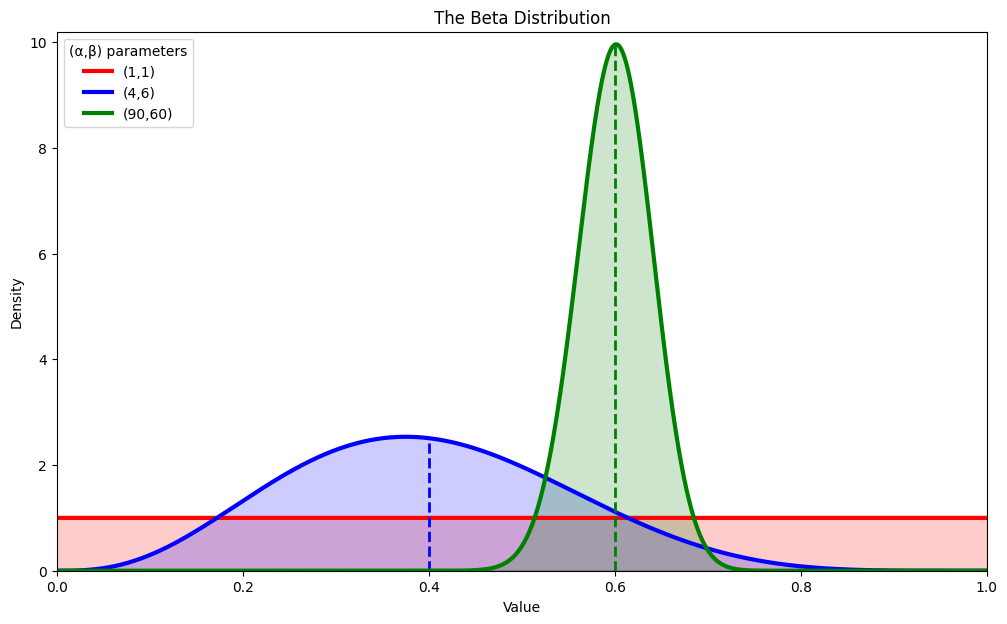

In [ ]:
beta = stats.beta

params = [(1, 1),(4,6),(90,60)]
x = np.linspace(0.0, 1.0, 10000)

plt.figure(figsize=(12,7))

colors = ["red","blue","green"]
c_index = 0

for α, β in params:
    y = beta.pdf(x, α, β)
    c = colors[c_index]
    lines = plt.plot(x,y,label = f"({α},{β})",lw = 3, color = c)
    plt.fill_between(x, 0, y, alpha = 0.2, color = c)

    if α > 1:
        mean = α/(α+β)
        plt.vlines(mean, 0, beta.pdf(mean, α, β), colors = c, linestyles = "--", lw = 2)

    plt.autoscale(tight=True)
    c_index += 1

plt.title('The Beta Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.ylim(0,10.2)
plt.legend(loc = 'upper left', title="(α,β) parameters");

## Bernoulli Socket Implementation

In [ ]:
class BernoulliThompsonSocket( PowerSocket ):
    def __init__( self, q ):

        self.α = 1  # the number of times this socket returned a charge
        self.β = 1  # the number of times no charge was returned

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def charge(self):
        """ return some charge with the socket's predefined probability """
        return np.random.random() < self.q

    def update(self,R):
        """ increase the number of times this socket has been used and
            update the counts of the number of times the socket has and
            has not returned a charge (alpha and beta)"""
        self.n += 1
        self.α += R
        self.β += (1-R)

    def sample(self):
        """ return a value sampled from the beta distribution """
        return np.random.beta(self.α,self.β)

### Experiment Results

In [ ]:
figsize(11.0, 10)
beta = stats.beta
x = np.linspace(0.0,1.0,200)

def plot_sockets(sockets, socket_probabilities ):

    trials = sum([socket.n for socket in sockets])

    colors = ["green","red","blue"]
    c_index = 0

    for i in range(len(socket_probabilities)):

        c = colors[c_index]
        y = beta( sockets[i].α, sockets[i].β )
        p = plt.plot(x, y.pdf(x), lw=2, color=c, label = f'{sockets[i].α-1}/{sockets[i].n}')
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        plt.vlines(socket_probabilities[i], 0, y.pdf(socket_probabilities[i]), colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

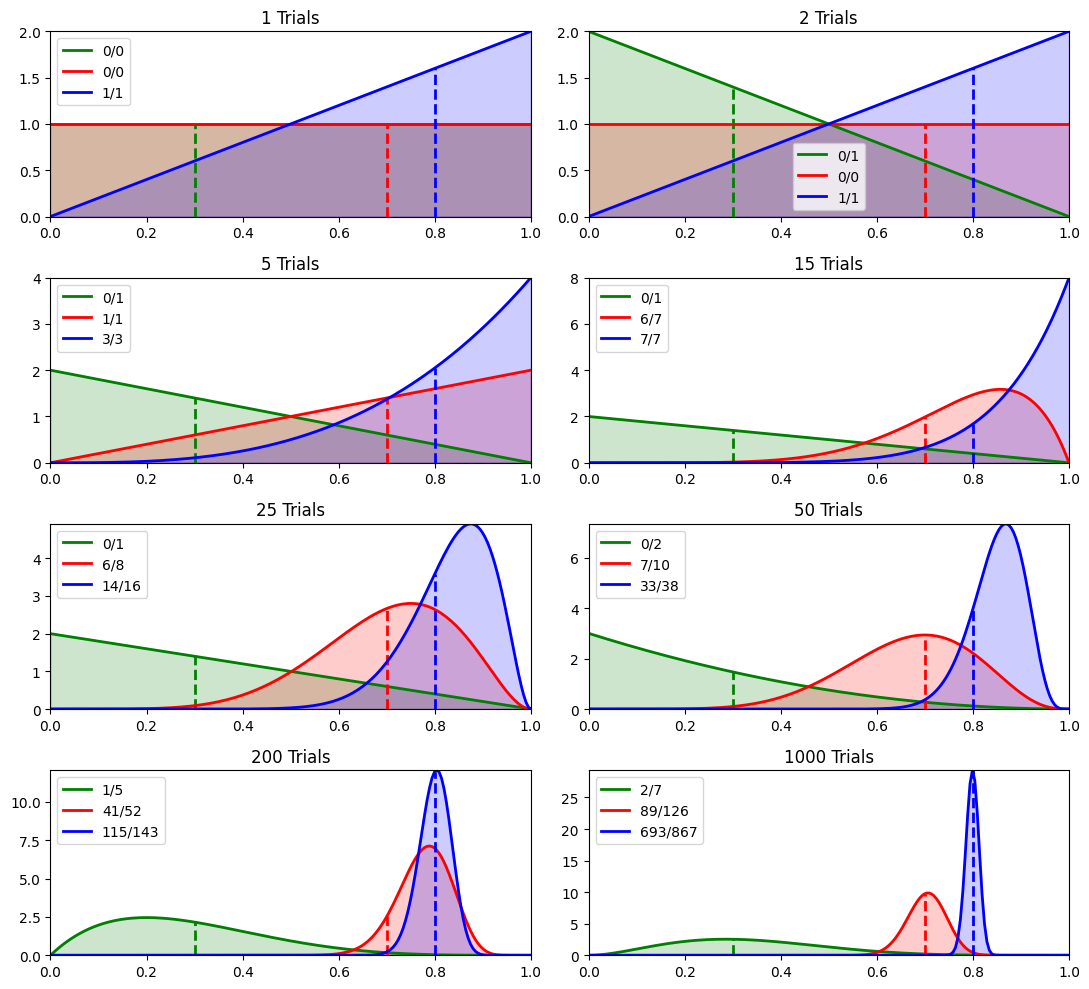

In [ ]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed)
np.random.seed(seed)

# the probabilities that each socket returns a charge
socket_probabilities = [0.3,0.7,0.8]

sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)

    for k in range(i):
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie
        socket_index = random_argmax([socket.sample() for socket in sockets])

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)

    plot_sockets(sockets, socket_probabilities)

    plt.autoscale(tight = True)
plt.tight_layout()

## Gaussian Thompson Sampling

### Gaussian Socket Implementation

In [ ]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self, q):

        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # do a standard update of the estimated mean
        super().update(R)

        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)
        self.τ_0 += 1

In [ ]:
def charge(self):
    """ return a random amount of charge """

    # the reward is a guassian distribution with unit variance
    # around the true value 'q'
    value = np.random.randn() + self.q

In [ ]:
def sample(self):
    """ return a value from the the posterior normal distribution """
    return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0

### Experiment Results

In [ ]:
figsize(11.0, 10)

norm = stats.norm
x = np.linspace(0.0,16.0,200)

def plot_sockets(sockets, socket_probabilities ):

    trials = sum([socket.n for socket in sockets])
    for socket in sockets:

        y = norm.pdf( x, socket.μ_0, np.sqrt(1./socket.τ_0) )
        p = plt.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y, 0, color=c, alpha=0.2 )
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)

True Values = [6, 4, 8, 12, 10]


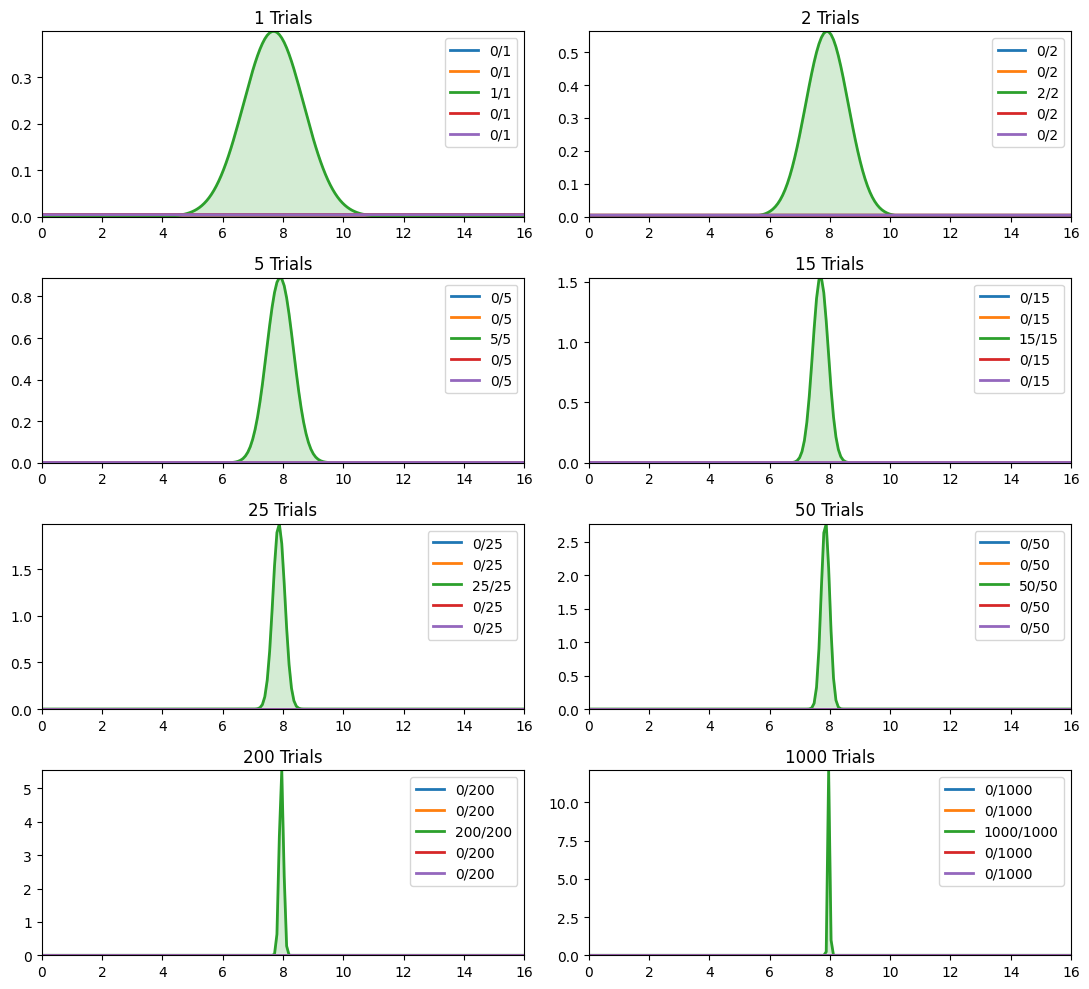

In [ ]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed)
np.random.seed(seed)

# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

socket_true_values = [((q*2)+2) for q in socket_order]

print(f"True Values = {socket_true_values}")

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [GaussianThompsonSocket(q) for q in socket_true_values]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)

    for k in range(i):

        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie
        #socket_samples = [socket.sample() for socket in sockets]
        #socket_index = random_argmax(socket_samples)

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)

    plot_sockets(sockets, socket_true_values)

    plt.autoscale(tight = True)
plt.tight_layout()

## Thompson Sampling Regret

In [ ]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 1000
number_of_steps = 1000

experiment = SocketExperiment(socket_tester   = SocketTester( GaussianThompsonSocket ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

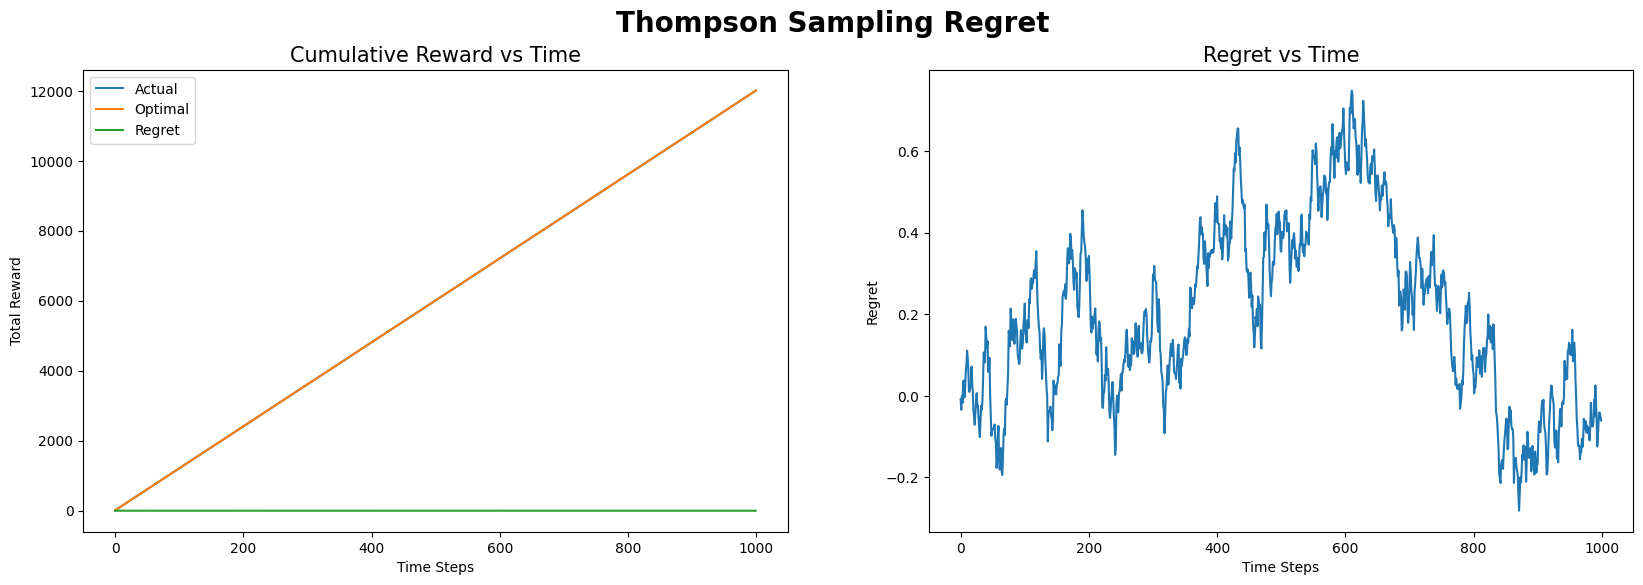

In [ ]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Thompson Sampling Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.show()

# **EXP - 3 - Baby Robot - PART 5b**

## Thompson Sampling using Conjugate Priors

### Setup and Utility Functions

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.core.pylabtools import figsize
norm = stats.norm
gamma = stats.gamma

# matplotlib setup
figsize(11.0, 10)
x = np.linspace(0.0,16.0,200)

In [3]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

In [4]:
def plot_pdf( trials, mean, variance, label, ymax = 0, set_height=False ):

  y = norm.pdf( x, mean, np.sqrt(variance) )

  p = plt.plot(x, y, lw=2, label = label )
  c = p[0].get_markeredgecolor()
  plt.fill_between(x, y, 0, color=c, alpha=0.2 )
  plt.legend()
  plt.autoscale(tight=True)

  plt.vlines(mean, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)
  if ymax == 0: ymax = y[1:].max()*1.1

  if set_height:
    axes = plt.gca()
    axes.set_ylim([0,ymax])

  return ymax


def plot_gamma( trials, alpha, beta, label, ymax = 0, precision = 0 ):

  variance = beta / (alpha + 1)

  y = stats.gamma.pdf(x, a=alpha, scale=1/beta)

  p = plt.plot(x, y, lw=2, label = f"var = {alpha/beta**2:.3f}" )
  c = p[0].get_markeredgecolor()

  plt.fill_between(x, y, 0, color=c, alpha=0.2 )

  # if supplied, show the true precision
  if precision > 0:
    plt.vlines(x=[precision], ymin=0, ymax=(y[1:].max()*1.1), colors = c, linestyles = "--", lw = 2)

  plt.title(f"{trials} Trials - Mean Precision = {1/variance:.2f}")
  plt.legend()
  plt.autoscale(tight=True)

  axes = plt.gca()
  axes.set_ylim([0,y[1:].max()*1.1])

figsize(11.0, 10)

norm = stats.norm
x = np.linspace(0.0,18.0,200)


def plot_socket_pdfs(sockets):

  ymax = 0
  for index, socket in enumerate(sockets):

    # get the PDF of the socket using its true values
    y = norm.pdf( x, socket.μ, np.sqrt(socket.v))

    p = plt.plot(x, y, lw=2, label = f"{index}" )
    c = p[0].get_markeredgecolor()
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(socket.μ, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)

    ymax = max( ymax, y[1:].max()*1.05 )

  axes = plt.gca()
  axes.set_ylim([0,ymax])

  plt.legend(title = 'Sockets')
  plt.title('Density Plot of Socket Outputs')
  plt.xlabel('Socket Output (seconds of charge)')
  plt.ylabel('Density')


def plot_socket( socket, ymax = 0, title = None ):
  ymax1 = plot_pdf( socket.n, socket.μ, socket.v, "True", ymax )
  ymax2 = plot_pdf( socket.n, socket.μ_0, socket.v_0, "Estimated", ymax )

  if title is None: title = f"{socket.n} Trials"
  plt.title(title)

  # if no vertical extent is set automatically add space at top
  # - chooses the max from the 2 plots and adds 5%
  if ymax == 0: ymax = max(ymax1,ymax2)*1.05
  axes = plt.gca()
  axes.set_ylim([0,ymax])


def plot_sockets(sockets, socket_probabilities ):

  trials = sum([socket.n for socket in sockets])
  plt.title(f"{trials} Trials")

  ymax = 0
  for index, socket in enumerate(sockets):

    # get the PDF of the socket using its estimates
    y = norm.pdf( x, socket.μ_0, np.sqrt(socket.v_0) )

    p = plt.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
    c = p[0].get_markeredgecolor()
    plt.fill_between(x, y, 0, color=c, alpha=0.2 )
    plt.legend()
    plt.autoscale(tight=True)

    plt.vlines(socket.μ_0, 0, y[1:].max(), colors = c, linestyles = "--", lw = 2)

    ymax = max( ymax, y[1:].max()*1.05 )

  axes = plt.gca()
  axes.set_ylim([0,ymax])

### Known Variance, Unknown Mean

In [5]:
class UnknownMeanKnownVariance:

    def __init__(self, μ, v):
        self.μ = μ   # the true mean
        self.v = v   # the true variance
        self.τ = 1/v # the true precision

        self.n = 0   # the number of times this socket has been tried
        self.x = []  # list of all samples

        self.μ_0 = 1 # the posterior (estimated) mean

        # the posterior variance
        # - we know this, so set it equal to the true variance
        self.v_0 = v

        # the sum of all individual precisions
        self.τ_0 = 0.0001

    def charge(self):
      ''' return a value using the true mean and variance for the socket '''

      # take the first (and only) value from the single item list
      value = np.random.normal( self.μ, np.sqrt(self.v), 1)[0]

      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value

    def sample(self):
      ''' return a value from the the prior normal distribution '''
      return np.random.normal( self.μ_0, np.sqrt(1/self.τ_0) )

    def update(self,x):
      ''' increase the number of times this socket has been used and improve the estimate of the
          value (the mean) by combining the new value 'x' with the current mean '''

      self.n += 1
      self.x.append(x)  # append the new value to the list of samples

      # update the mean of the posterior
      self.μ_0 = ((self.τ_0 * self.μ_0) + (self.τ * np.array(self.x).sum()))/(self.τ_0 + (self.n*self.τ))

      # increase the sum of all precisions
      self.τ_0 = self.n * self.τ

In [6]:
''' set the default values to use for the test socket '''
mean = 8
variance = 5

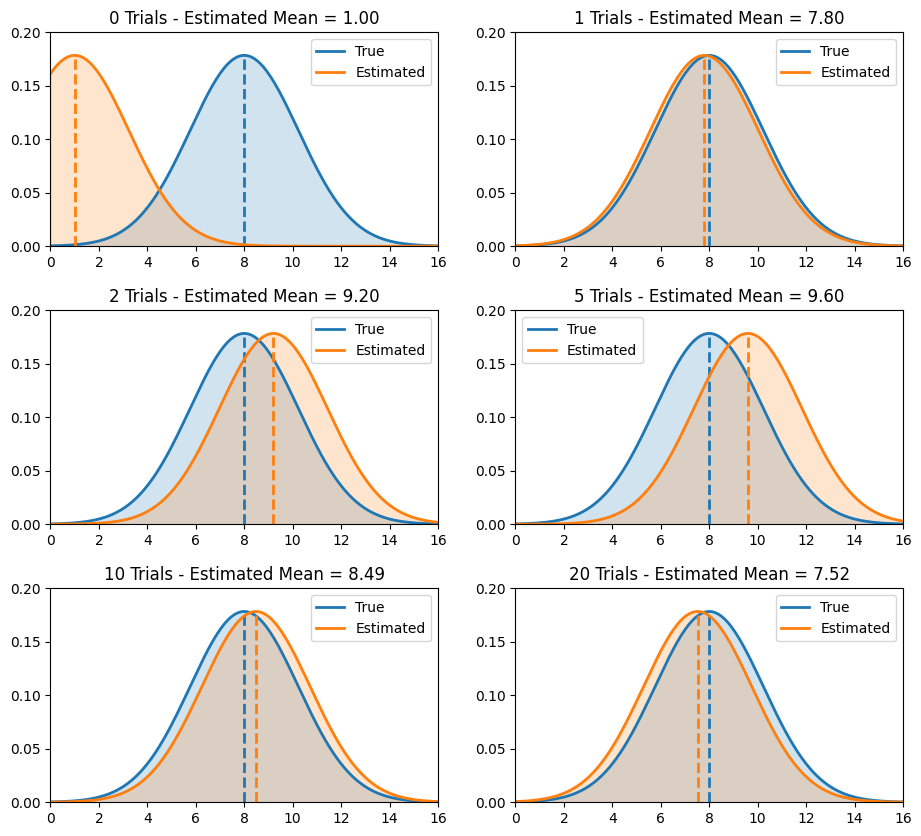

In [7]:
socket = UnknownMeanKnownVariance( mean, variance )

draw_samples = [0, 1, 1, 3, 5, 10]

x = np.linspace(0.0,16.0,200)
figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)
  plt.subplots_adjust(hspace = 0.3)
  for k in range(i):
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)

  plot_socket( socket, ymax = 0.2, title = f"{socket.n} Trials - Estimated Mean = {socket.μ_0:.2f}")
# plt.savefig("Images/unknown_mean_known_variance.png",bbox_inches='tight')

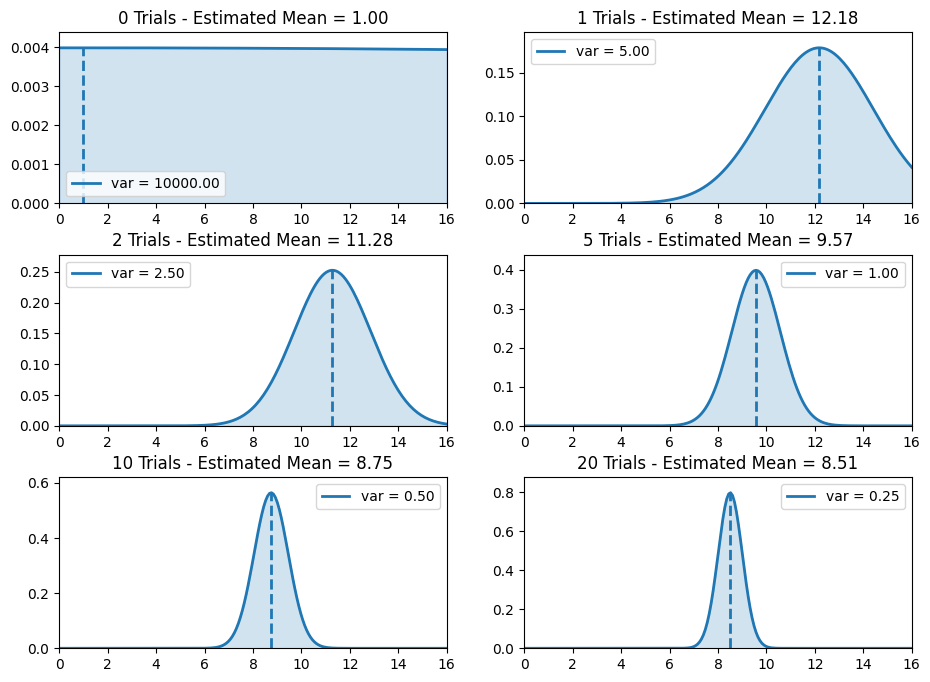

In [8]:
socket = UnknownMeanKnownVariance( mean, variance )

x = np.linspace(0.0,16.0,200)
figsize(11.0, 8)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)
  plt.subplots_adjust(hspace = 0.3)
  for k in range(i):
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)

  plot_pdf( socket.n, socket.μ_0, 1/socket.τ_0, f"var = {1/socket.τ_0:.2f}",set_height=True)
  plt.title(f"{socket.n} Trials - Estimated Mean = {socket.μ_0:.2f}")

# plt.savefig("Images/unknown_mean_known_variance_prior.png",bbox_inches='tight')

### Unknown Variance, Known Mean

In [9]:
class KnownMeanUnknownVariance:

    def __init__(self, μ, v):
        self.μ = μ   # the true mean
        self.v = v   # the true variance

        self.n = 0   # the number of times this socket has been tried
        self.x = []  # list of all samples

        # the posterior (estimated) mean
        # - we know this, so set it equal to the true mean
        self.μ_0 = μ

        # the posterior (estimated) variance
        self.v_0 = 1

        self.α = 1   # gamma shape parameter
        self.β = 1   # gamma rate parameter

    def charge(self):
      ''' return a value using the true mean and variance for the socket '''

      # take the first (and only) value from the single item list
      value = np.random.normal( self.μ, np.sqrt(self.v), 1)[0]

      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value

    def sample(self):
      ''' sample from our estimated normal
        - this uses the estimated mean and the true variance '''

      # using gamma function directly gives estimate of precision
      # - inverse gamma would give variance
      # np's gamma fn takes 'scale' as its second parameter which is 1/β
      # convert back from precision to variance
      return 1/np.random.gamma(self.α, 1/self.β)

    def update(self,x):
      ''' increase the number of times this socket has been used and improve the estimate of the
          variance by updating the gamma distribution's hyper-parameters using the new value 'x' '''

      self.n += 1
      self.x.append(x)  # append the new value to the list of samples

      self.α = self.n/2
      self.β = ((np.array(self.x) - self.μ)**2).sum()/2

      # estimate the variance - calculate the mean from the gamma hyper-parameters
      self.v_0 = self.β / (self.α + 1)

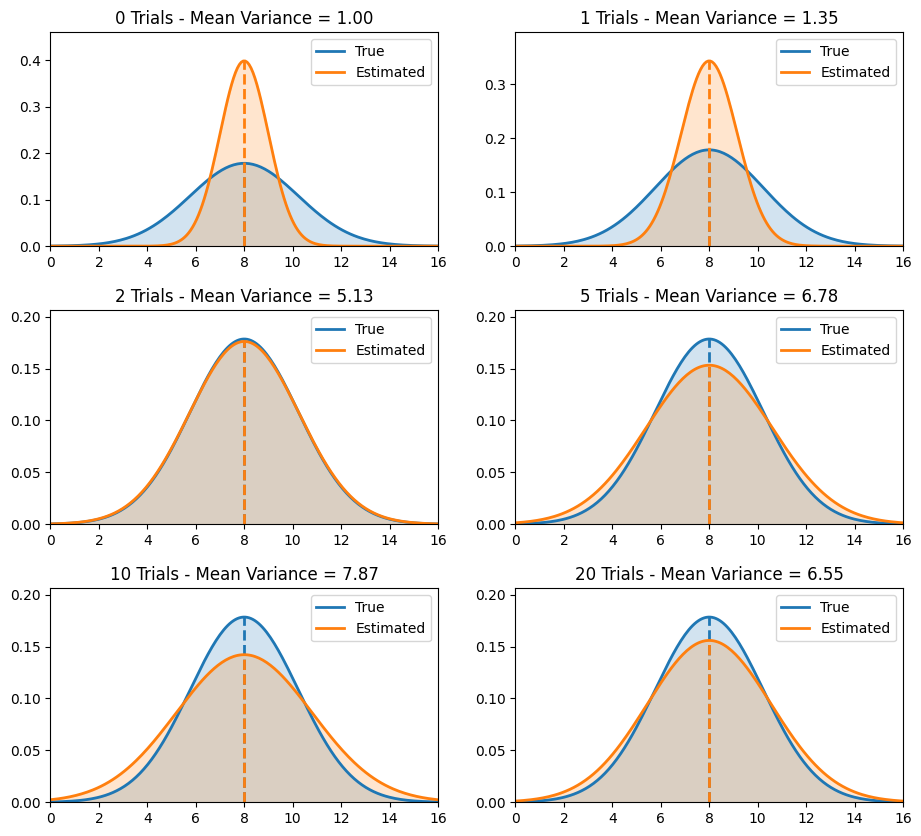

In [10]:
socket = KnownMeanUnknownVariance( mean, variance )
draw_samples = [0, 1, 1, 3, 5, 10]

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)
  plt.subplots_adjust(hspace = 0.3)

  for k in range(i):
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)

  plot_socket( socket, title = f"{socket.n} Trials - Mean Variance = {socket.v_0:.2f}")

# plt.savefig("Images/known_mean_unknown_variance.png",bbox_inches='tight')

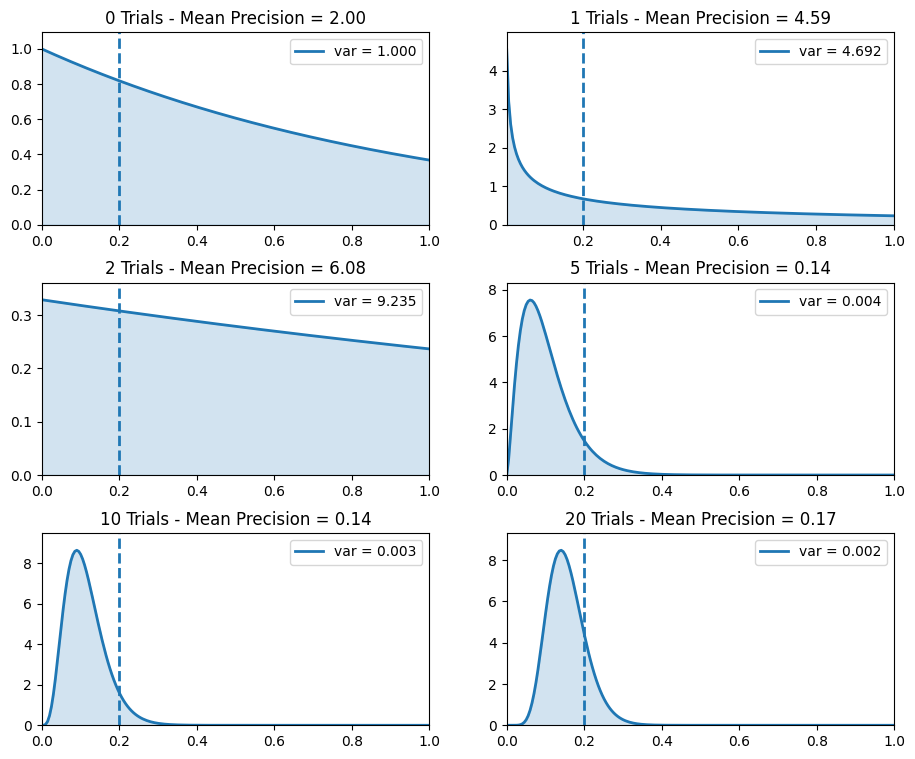

In [12]:
socket = KnownMeanUnknownVariance( mean, variance )
x = np.linspace(0.0,1.0,200)

figsize(11.0, 9)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)
  plt.subplots_adjust(hspace = 0.3)

  for k in range(i):
    # charge from the socket and update its value
    reward = socket.charge()
    socket.update(reward)

  plot_gamma( socket.n, socket.α, socket.β, f"{1/socket.v_0}", precision = 1/socket.v )

# plt.savefig("Images/known_mean_unknown_variance_prior.png",bbox_inches='tight')

### Unknown Variance, Unknown Mean

In [13]:
class UnknownMeanUnknownVariance:

    def __init__(self, μ, v):
      self.μ = μ   # the true mean
      self.v = v   # the true variance

      self.n = 0   # the number of times this socket has been tried
      self.x = []  # list of all samples

      self.α = 1   # gamma shape parameter
      self.β = 10  # gamma rate parameter

      self.μ_0 = 1 # the prior (estimated) mean
      self.v_0 = self.β / (self.α + 1) # the prior (estimated) variance

    def update(self,x):
      ''' increase the number of times this socket has been used and improve the estimate of the
          mean and variance by combining the single new value 'x' with the current estimate '''
      n = 1
      v = self.n

      self.α = self.α + n/2
      self.β = self.β + ((n*v/(v + n)) * (((x - self.μ_0)**2)/2))

      # estimate the variance - calculate the mean from the gamma hyper-parameters
      self.v_0 = self.β / (self.α + 1)

      self.x.append(x)  # append the new value to the list of samples
      self.n += 1
      self.μ_0 = np.array(self.x).mean()

    def charge(self):
      ''' return a value using the true mean and variance for the socket '''
      value = np.random.normal( self.μ, np.sqrt(self.v) )

      # never allow a charge less than 0 to be returned
      return 0 if value < 0 else value

    def sample(self):
      ''' sample from our estimated normal '''

      precision = np.random.gamma(self.α, 1/self.β)
      if precision == 0 or self.n == 0: precision = 0.001

      estimated_variance = 1/precision
      return np.random.normal( self.μ_0, np.sqrt(estimated_variance))

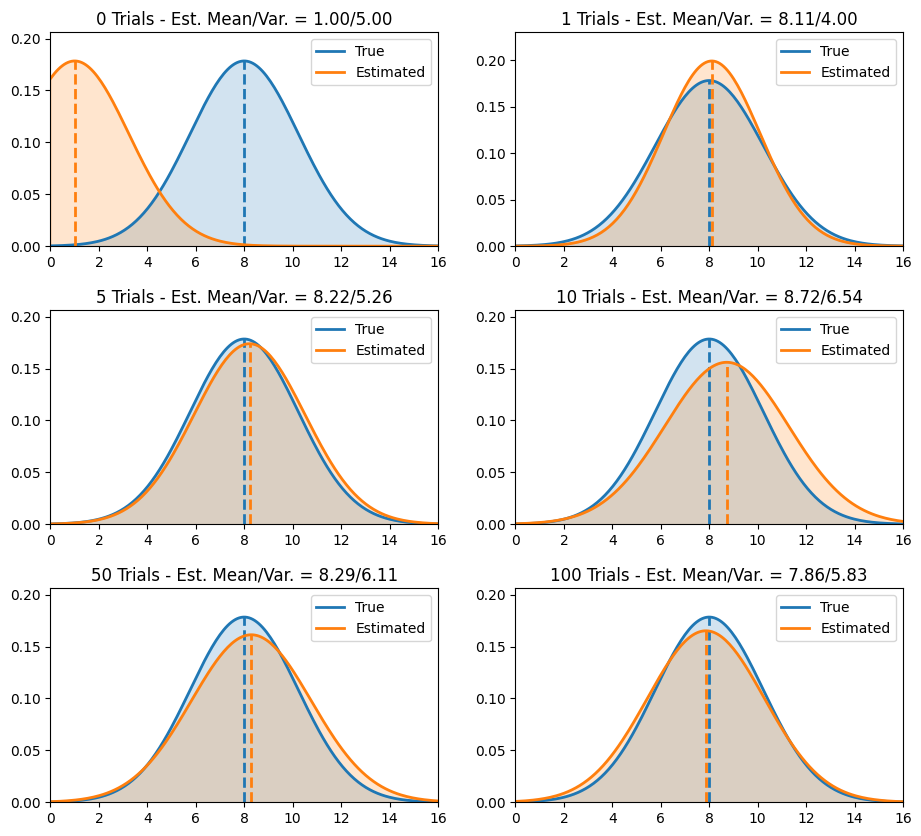

In [14]:
socket = UnknownMeanUnknownVariance( mean, variance )

draw_samples = [0, 1, 4, 5, 40, 50]
x = np.linspace(0.0,16.0,200)

figsize(11.0, 10)
for j,i in enumerate(draw_samples):
  plt.subplot(3, 2, j+1)
  plt.subplots_adjust(hspace = 0.3)

  for k in range(i):
    reward = socket.charge()
    socket.update(reward)

  title = f"{socket.n} Trials - Est. Mean/Var. = {socket.μ_0:0.2f}/{socket.v_0:.2f}"
  plot_socket( socket, title = title )

# plt.savefig("Images/unknown_mean_unknown_variance.png",bbox_inches='tight')

### Bandit Problem with Unknown Mean and Unknown Variance

In [15]:
socket_true_values = [6, 10, 8, 12, 11]
socket_variance = [2,5,3,1,6]

print(f"True Values = {socket_true_values}")
print(f"Variances = {socket_variance}")

True Values = [6, 10, 8, 12, 11]
Variances = [2, 5, 3, 1, 6]


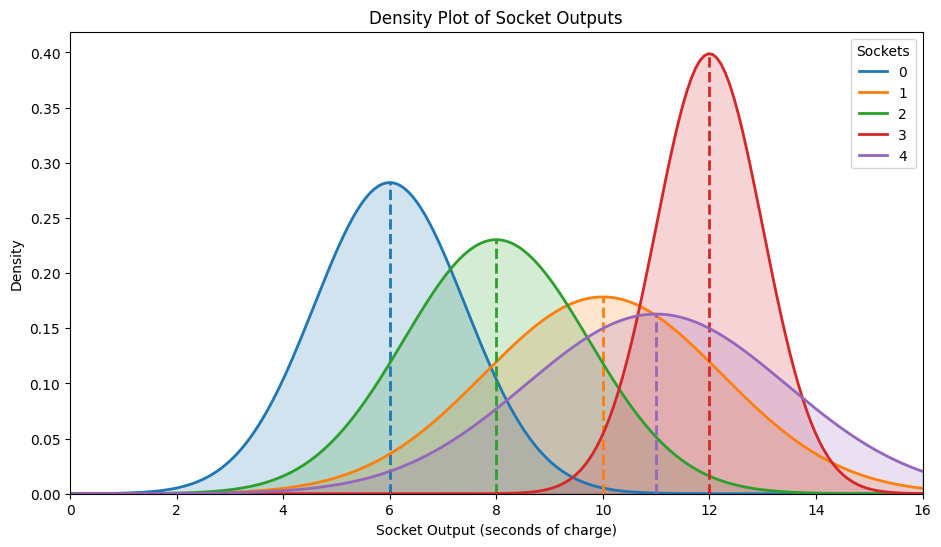

In [17]:
# create the sockets
sockets = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(socket_true_values, socket_variance)]

figsize(11.0, 6)
plot_socket_pdfs( sockets )
#plt.savefig("Images/unknown_mean_unknown_variance_pdf.png",bbox_inches='tight')

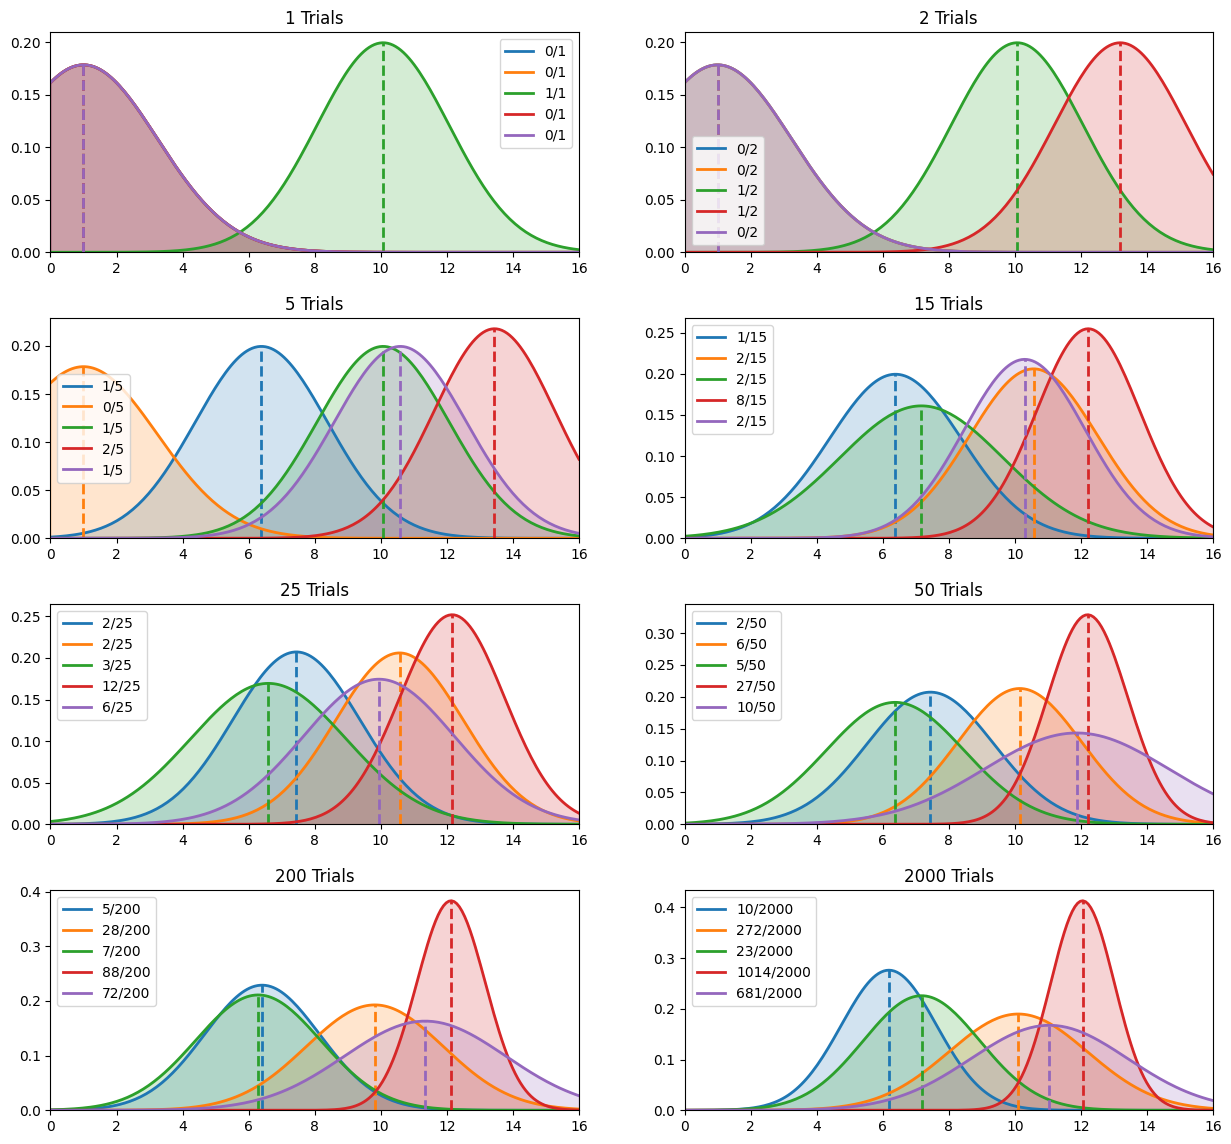

In [18]:
%matplotlib inline
sockets = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(socket_true_values, socket_variance)]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 1800]
x = np.linspace(0.0,16.0,200)

figsize(15.0, 14)
for j,i in enumerate(draw_samples):
  plt.subplot(4, 2, j+1)
  plt.subplots_adjust(hspace = 0.3)

  for k in range(i):
    # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie
    socket_samples = [socket.sample() for socket in sockets]
    socket_index = random_argmax(socket_samples)

    # charge from the chosen socket and update its mean reward value
    reward = sockets[socket_index].charge()
    sockets[socket_index].update(reward)

  plot_sockets(sockets, socket_true_values)

# plt.savefig("Images/thompson_unknown_mean_unknown_variance.png",bbox_inches='tight')

In [19]:
%%capture
# stop the initial figure from being shown

from matplotlib.animation import FuncAnimation
from IPython.core.pylabtools import figsize
from IPython.display import HTML
import scipy.stats as stats
norm = stats.norm

x = np.linspace(0.0,18.0,200)

# setup the axis of the figure
figsize(11.0, 6)
fig = plt.figure()
ax = plt.axes(xlim=(2, 16), ylim=(0, 0.5))

plt.title('Density Plot of Socket Outputs')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')

# define a text list for the legend - standard legends dont work well with animation
texts = [ax.text(0.88, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(len(sockets)+2)]
texts[1].set_text('sockets:')

lines = []
for index in range(len(sockets)):
  lobj = ax.plot([],[],lw=2)[0]
  lines.append(lobj)


# animation initialisation
def init():
  for line in lines:
      line.set_data([],[])
  return lines


# animate function called at each step
def animate(i):

  # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie
  socket_samples = [socket.sample() for socket in sockets]
  socket_index = random_argmax(socket_samples)

  # charge from the chosen socket and update its mean reward value
  reward = sockets[socket_index].charge()
  sockets[socket_index].update(reward)

  texts[0].set_text(f'trials: {i}')

  ax.collections.clear()
  for index, socket in enumerate(sockets):

    y = norm.pdf( x, socket.μ_0, np.sqrt(socket.v_0) )

    line = lines[index]
    line.set_data(x, y)
    texts[index+2].set_text(f'     {index}: {socket.n}')

    c = line.get_markeredgecolor()
    ax.fill_between(x, y, 0, color=c, alpha=0.2 )

    # add the coloured lines to the legend
    ax.hlines(y=0.431-index*0.0245, xmin=14.3, xmax=14.6, linewidth=3, color=c)

  return lines

In [23]:
%matplotlib notebook
''' Run the test and show the results - this can take a while before the image is shown '''
sockets = [ UnknownMeanUnknownVariance(m,v) for (m, v) in zip(socket_true_values, socket_variance)]
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)
#HTML(anim.to_jshtml())